# Breast Cancer Predicition Model

Mallika Sansgiri, Chandni Rajasekaran, Vaishnavi Dontineni

In [149]:
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from pandas.io.json import json_normalize

In [150]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame


# Getting the Data

Data is stored in a google spreadsheet and retrieved here 

In [151]:
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('./mrtutoring-1ed099ef30fd.json', scope)
gc = gspread.authorize(credentials)

In [152]:
spreadsheet_key = '1E4_GzXYpQDldZP0jVgAMeuS2iutICLWEdSlRvawjTpA'
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet("data")
table = worksheet.get_all_values()


Turning the csv data from the spreadsheet into a pandas dataframe so it can be used in this model

In [153]:
df = pd.DataFrame(table[1:], columns=table[0])


# Processing the Data

Dropping the id column because it is useless when training the model

In [154]:
df.drop(['id' ] , axis= 1, inplace = True)


Getting rid of any non numeric data and altering it so it is numeric. The M and B in the diagnosis column gets turned into the binary 0 and 1 

In [155]:
#counting the instances of B and M for graphing
mc = 0
bc = 0
for i, row in df.iterrows():
    if(row['diagnosis'] == 'M'):
        row['diagnosis'] = 1
        mc += 1
    else :
        row['diagnosis'] = 0
        bc += 1
    

Converting all the data from objects to floats so it can be feature engineered and trained.
Running the describe method on the dataframe to get an idea of the normality of the data

In [157]:
for i in df.columns.tolist():
    df[i] = df[i].astype(float)
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# Graphically Analyzing the Data

Graphing the diagnosis data to get a general look of the distribution of the data

<function matplotlib.pyplot.show(*args, **kw)>

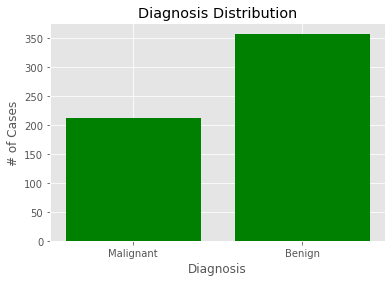

In [156]:
plt.style.use('ggplot')
x = ['Malignant', 'Benign']
value = [mc, bc]
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, value, color='green')
plt.xlabel("Diagnosis")
plt.ylabel("# of Cases")
plt.title("Diagnosis Distribution")

plt.xticks(x_pos, x)
plt.show

Running the Correlaton method to see the correlation (0-1) of each data point in relation to each other. 1 represents perfect linear correlation and 0 represents no correlation. 

In [158]:
df.corr()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.730029,0.415185,0.742636,0.708984,0.358560,0.596534,0.696360,0.776614,0.330499,...,0.776454,0.456903,0.782914,0.733825,0.421465,0.590998,0.659610,0.793566,0.416294,0.323872
radius_mean,0.730029,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.415185,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.742636,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.708984,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.358560,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.596534,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.696360,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.776614,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.330499,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


In [159]:
#Getting a list of the columns in the correlation dataframe 
cl = df.corr().columns.tolist()

Determining which columns are highly correlated and therefor will not add help our model
The threshold can be toggled for various levels of correlation

In [160]:
threshold = 0.89
#The set we plan to drop in our dataset 
dropset = set([])
# Iterating through the rows in the correlation dataframe and adding the rows 
#with a high correlation to the dropset
for i, row in df.corr().iterrows():
    for column in cl:
        #Adding a column assuming it's not the same one being compared and its greater than the threshold
        if row[column] < 1.0 and row[column] > threshold:
            myset.add(column)
        

In [161]:
print(dropset)

set()


Visualization of the correlation data in a heat map. The lighter the areas the stronger the correlation

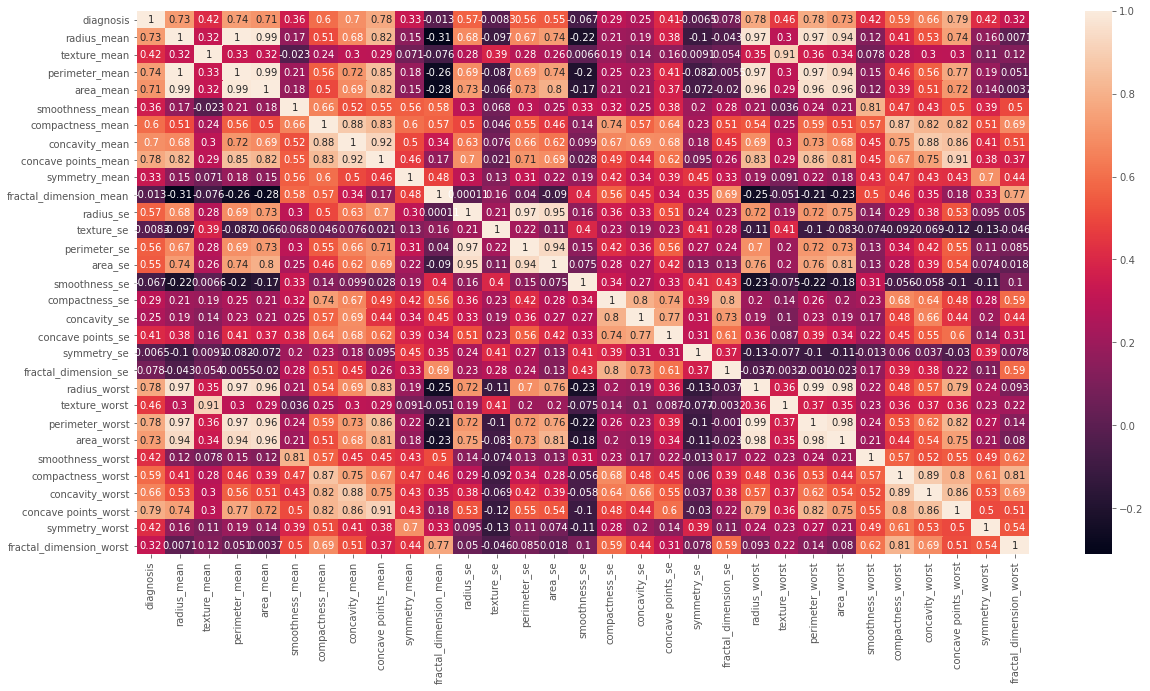

In [162]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot=True)
plt.show()

# Preprocessing and Feature Engineering 

Altering the data by dropping the excess data points
Splitting the data into the labels and the trainable data

In [163]:
ml_data = df.drop(dropset, axis=1)
data = ml_data.drop(['diagnosis'] , axis = 1)
labels = ml_data['diagnosis']

In [164]:
#Splitting the Data into the training and testing data
#The testing data is 30 percent of the 
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, test_size=0.3, random_state=123)

Creating 2 more datasets:
Normalized data : Rescaling the data into a 0.0-1.0 range
Standardized data : Takes normalized data a makes the mean of the data 0 and the standard deviation 1

In [165]:
norm = MinMaxScaler().fit(data_train)
std = StandardScaler().fit(data_train)
# transform training data
data_train_norm = norm.transform(data_train)
data_test_norm = norm.transform(data_test)

data_test_std = std.transform(data_test)
data_train_std = std.transform(data_train)

# Creating the Models

Creating the models we choose to use to train our data with


In [166]:
#Standard model type initialization
lr = LogisticRegression(max_iter = 200, n_jobs=-1, random_state=123)
knn = KNN()
dt = DecisionTreeClassifier(random_state=123)

rf = RandomForestClassifier(random_state=123)

# Define a list called classifier that contains the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),
('K Nearest Neighbours', knn),
('Random Forest Classifier', rf),
('Decision Tree', dt)]              

# Testing the Models 

Iterated throught the classifiers and fits the models to the training data and labels and predicts on the testing data
The accuracy is printed next to the model 

In [167]:
#Normal Data
for clf_name, clf in classifiers:
    
    clf.fit(data_train_norm, labels_train)
    
    label_pred = clf.predict(data_test_norm)
   
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(labels_test, label_pred)))

Logistic Regression : 0.971
K Nearest Neighbours : 0.988
Random Forest Classifier : 0.982
Decision Tree : 0.942


Iterated throught the classifiers and fits the models to the training data and labels and predicts on the testing data
The accuracy is printed next to the model 

In [168]:
#Standardized Data
for clf_name, clf in classifiers:
    
    clf.fit(data_train_std, labels_train)
    
    label_pred = clf.predict(data_test_std)
   
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(labels_test, label_pred)))

Logistic Regression : 0.994
K Nearest Neighbours : 0.977
Random Forest Classifier : 0.982
Decision Tree : 0.942


Iterated throught the classifiers and fits the models to the training data and labels and predicts on the testing data 
The accuracy is printed next to the model 

In [169]:
#Original Data
for clf_name, clf in classifiers:
    
    clf.fit(data_train, labels_train)
    
    label_pred = clf.predict(data_test)
   
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(labels_test, label_pred)))

Logistic Regression : 0.982
K Nearest Neighbours : 0.930
Random Forest Classifier : 0.982
Decision Tree : 0.942


# Choosing the Best Model

Using the best model which was the Logistic Regression Model trained with standardized data

In [170]:
data_for_testing = data_test[5:6]

lr.fit(data_train_std, labels_train)
prediction = clf.predict(data_for_testing)
if prediction == 0.0:
    print('Benign')
else :
    print('Malignant')

Benign
